In [1]:
import os
import numpy as np
import glob

import warnings  # Ignore sklearn future warning
warnings.simplefilter(action='ignore', category=FutureWarning)
from lib.utils import setup_save_n_log, get_per_pt, set_grad_req, setup_save_dir
import numpy as np
import torch
import logging
from lib.fMRI import fMRI_Time_Subjs_Dataset, fMRI_Time_Subjs_Embed_Dataset, fMRIAutoencoderDataset
from torch.utils.data import DataLoader
from lib.autoencoder import Encoder_conv,Decoder_conv, Encoder_basic, Decoder_basic, Decoder_Manifold
import random
from lib.utils import save_checkpoint_allin1
import os
import matplotlib.pyplot as plt
import argparse
from lib.helper import pearsonr_loss, MMD_loss, drive_decoding
from lib.utils_Erica import time_segment_matching, ISC
import pandas as pd
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install ortools

In [2]:
ROI = "early_visual"
phate_save_name = f'movie_{ROI}_lam0.0_manilam0.1_display_half1.jpg'
test_path = None
datapath = f"/gpfs/milgram/scratch60/turk-browne/neuromanifold/StudyForrest/MNI152_3mm_data/denoised_filtered_smoothed/ROI_data/{ROI}/data"
loadpath = "/gpfs/milgram/scratch60/turk-browne/tw496/results/forrest_paper_10pt_hiddendim64_bs64_mlp_md_mse_reg_lam5.0_manilam0.1_phate_shf"
load_epoch = 4000

# test_path = None
# test_range = None
test_path = f"/gpfs/milgram/scratch60/turk-browne/neuromanifold/StudyForrest/MNI152_3mm_data/denoised_filtered_smoothed/ROI_data/{ROI}/data"
test_range = 624
testnaming= f"{ROI}_localizer_all_runs.npy"

n_TR = 3599
# TR_range = 2
data_3d=False,
datanaming=f"{ROI}_movie_all_runs.npy"

hidden_dim = 64
embed_size = 20

ae_type = 'mlp_md'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [83]:
# print('extract hidden rep and calculate metrics and produce phate plots')

# if test_path is None:
#     if TR_range is not None:
#         # cross-validate the other half. e.g. trained model on the first half data, then apply the trained model on the second half
#         if TR_range == 2:
#             TR_range = np.arange(n_TR)
#         else:
#             TR_range = np.arange(n_TR, 2 * n_TR)
#     else:
#         TR_range = np.arange(n_TR)

#     print(f'apply trained model on {TR_range} half to data[{TR_range[0]}-{TR_range[-1]}]')

#     checkpoint = torch.load(os.path.join(loadpath, f'ae_e{load_epoch}.pt'))

#     # load dataset
#     if 'StudyForrest' in datapath:
#         # patient_ids = [1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 17, 18, 19, 20]
#         patient_ids = [1, 2, 3, 4, 5, 6, 9, 10, 14, 15]
#     else:
#         patient_ids = np.arange(1, n_pt + 1)

#     dataset = fMRIAutoencoderDataset(patient_ids,
#                                     datapath,
#                                     TR_range,
#                                     data_3d=False,
#                                     data_name_suffix=datanaming)
    
#     train_means, train_stds = dataset.preprocess_center_normalize1()

#     if len(dataset) != n_TR * len(patient_ids):
#         print('Error: dataset timepoints not equal to desired timepoints.')
# else:
#     TR_range = np.arange(3599)
#     patient_ids = [1, 2, 3, 4, 5, 6, 9, 10, 14, 15]
#     dataset_pre = fMRIAutoencoderDataset(patient_ids,
#                                     datapath,
#                                     TR_range,
#                                     data_3d=False,
#                                     data_name_suffix=datanaming)
    
#     train_means, train_stds = dataset_pre.preprocess_center_normalize1()
    
    
#     TR_range = np.arange(test_range)

#     print(f'apply trained model on {test_path} -- timesteps: {TR_range[0]}-{TR_range[-1]}]')

#     checkpoint = torch.load(os.path.join(loadpath, f'ae_e{load_epoch}.pt'))

#     # load dataset
#     if 'StudyForrest' in datapath:
#         # patient_ids = [1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 17, 18, 19, 20]
#         patient_ids = [1, 2, 3, 4, 5, 6, 9, 10, 14, 15]
#     else:
#         patient_ids = np.arange(1, n_pt + 1)

#     dataset = fMRIAutoencoderDataset(patient_ids,
#                                     test_path,
#                                     TR_range,
#                                     data_3d=False,
#                                     data_name_suffix=testnaming)
    
#     dataset.preprocess_center_normalize1(train_means, train_stds)

    
# input_size = 166

extract hidden rep and calculate metrics and produce phate plots
loading data from patient 1 into memory
loading data from patient 2 into memory
loading data from patient 3 into memory
loading data from patient 4 into memory
loading data from patient 5 into memory
loading data from patient 6 into memory
loading data from patient 9 into memory
loading data from patient 10 into memory
loading data from patient 14 into memory
loading data from patient 15 into memory
apply trained model on /gpfs/milgram/scratch60/turk-browne/neuromanifold/StudyForrest/MNI152_3mm_data/denoised_filtered_smoothed/ROI_data/early_visual/data -- timesteps: 0-623]
loading data from patient 1 into memory
loading data from patient 2 into memory
loading data from patient 3 into memory
loading data from patient 4 into memory
loading data from patient 5 into memory
loading data from patient 6 into memory
loading data from patient 9 into memory
loading data from patient 10 into memory
loading data from patient 14 into 

In [84]:
# input_size

166

In [85]:
# encoder = Encoder_basic(input_size, hidden_dim * 4, hidden_dim * 2, hidden_dim)
# encoder.load_state_dict(checkpoint['encoder_state_dict'])
# encoder.to(device)
# decoders = []
# for i in range(1, len(patient_ids)+1):
#     decoder = Decoder_Manifold(embed_size, hidden_dim, hidden_dim*2, hidden_dim*4, input_size)
#     decoder.load_state_dict(checkpoint[f'decoder_{i}_state_dict'])
#     decoder.to(device)
#     decoders.append(decoder)

# # initialize optimizer
# params = list(encoder.parameters())
# for decoder in decoders:
#     params = params + list(decoder.parameters())
# optimizer = torch.optim.Adam(params, lr=0.001)  # either set initial lr or default 0.001
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# epoch = checkpoint['epoch']

In [86]:
# def extract_hidden_reps(encoder, decoders, dataset, device, amlps, ae_type, n_TR):
#     # idx is pt-1 to index the mlp
#     encoder.eval()
#     for decoder in decoders:
#         decoder.eval()
#     if amlps is not None:
#         for mlp in amlps:
#             mlp.eval()

#     hidden_reps = []
#     aligned_hidden_reps = []
#     for i in range(len(dataset)):
#         print(dataset[i].shape)
#         input_TR = dataset[i]
#         input_TR = torch.from_numpy(input_TR)
#         input_TR = input_TR.unsqueeze(0).unsqueeze(0)
#         input_TR = input_TR.float().to(device)
#         if ae_type == 'conv':
#             hidden, _,_ = encoder(input_TR)
#         elif ae_type =='mlp':
#             hidden = encoder(input_TR)
#         elif ae_type =='mlp_md':
#             common_hidden = encoder(input_TR)
#             pt = i//n_TR
#             decoders[pt].eval()
#             hidden, _= decoders[pt](common_hidden)
#             aligned_hidden_reps.append(common_hidden.detach().cpu().numpy().flatten())

#         if amlps is not None:
#             idx = i//n_TR
#             aligned_hidden = amlps[idx](hidden)
#             aligned_hidden = aligned_hidden.detach().cpu().numpy().flatten()
#             aligned_hidden_reps.append(aligned_hidden)


#         hidden = hidden.detach().cpu().numpy().flatten()
#         hidden_reps.append(hidden)
#     hidden_reps = np.vstack(hidden_reps)
#     if amlps or ae_type=='mlp_md':
#         aligned_hidden_reps = np.vstack(aligned_hidden_reps)
#     return hidden_reps, aligned_hidden_reps

In [87]:
# # continue to use the last state of encoder and decoder from training so that no need to load the saved checkpoints.
# latent_mlps = None

# encoder.eval()
# hidden, al_hidden = extract_hidden_reps(encoder, decoders, dataset, device, latent_mlps, ae_type, n_TR)

# print(al_hidden.shape)
# print(hidden.shape)
# print('-------')

# # test_range = None
# if test_range:
#     hidden = hidden.reshape(len(patient_ids), test_range, -1) # hidden is all patients, and interested timepoints
# else:
#     hidden = hidden.reshape(len(patient_ids), n_TR, -1)

# # if args.amlp or args.ae_type == 'mlp_md':
# if ae_type == 'mlp_md':
#     if test_range:
#         al_hidden = al_hidden.reshape(len(patient_ids), test_range, -1)
#     else:
#         al_hidden = al_hidden.reshape(len(patient_ids), n_TR, -1)

(624, 166)
(624, 166)
(624, 166)
(624, 166)
(624, 166)
(624, 166)
(624, 166)
(624, 166)
(624, 166)
(624, 166)
(10, 39936)
(10, 12480)
-------


In [88]:
# al_hidden.shape

(10, 624, 64)

In [89]:
# hidden.shape

(10, 624, 20)

In [90]:
# import phate


al_hidden = al_hidden.reshape(len(patient_ids) * test_range, -1)
phate_op = phate.PHATE()
data_phate = phate_op.fit_transform(al_hidden)

Calculating PHATE...
  Running PHATE on 6240 observations and 64 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 2.87 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 2.92 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.36 seconds.
    Calculating KMeans...
    Calculated KMeans in 32.15 seconds.
  Calculated landmark operator in 33.27 seconds.
  Calculating optimal t...
    Automatically selected t = 25
  Calculated optimal t in 2.94 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 28.32 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.65 seconds.
Calculated PHATE in 73.12 seconds.


In [91]:
data_phate.shape

(6240, 2)

<AxesSubplot:>

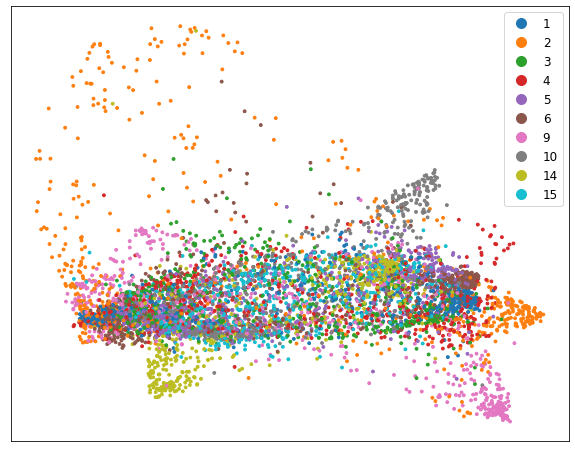

In [92]:
import scprep

n_embeds_per_pt = data_phate.shape[0] // len(patient_ids)

pid_labels = []

# for i in range(1, 15):
for i in patient_ids:
    pid_labels.extend([i] * n_embeds_per_pt)
pid_labels = np.array(pid_labels)

assert(len(pid_labels) == data_phate.shape[0])

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
scprep.plot.scatter2d(data_phate, c=pid_labels, discrete=True, ticks=False, legend=True, ax=ax, s=8)

# plt.savefig(phate_save_name)

## Raw dataset

In [10]:
# datapath = f"/gpfs/milgram/scratch60/turk-browne/neuromanifold/StudyForrest/MNI152_3mm_data/denoised_filtered_smoothed/ROI_data/{ROI}/data"

# TR_range = np.arange(3599)
# n_TR = 3599//2
# TR_half = 2

# if TR_half == 2:
#     TR_range = np.arange(n_TR)
# else:
#     TR_range = np.arange(n_TR, 2 * n_TR)

# patient_ids = [1, 2, 3, 4, 5, 6, 9, 10, 14, 15]
# dataset_pre = fMRIAutoencoderDataset(patient_ids,
#                                 data_path,
#                                 TR_range,
#                                 data_3d=False,
#                                 data_name_suffix=datanaming)

# train_means, train_stds = dataset_pre.preprocess_center_normalize1()


# if TR_half == 1:
#     TR_range = np.arange(n_TR)
# else:
#     TR_range = np.arange(n_TR, 2 * n_TR)


# TR_range = np.arange(test_range)

# print(f'apply trained model on {test_path} -- timesteps: {TR_range[0]}-{TR_range[-1]}]')

# checkpoint = torch.load(os.path.join(loadpath, f'ae_e{load_epoch}.pt'))

# load dataset
if 'StudyForrest' in datapath:
    # patient_ids = [1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 17, 18, 19, 20]
    patient_ids = [1, 2, 3, 4, 5, 6, 9, 10, 14, 15]
else:
    patient_ids = np.arange(1, n_pt + 1)

TR_range = np.arange(test_range)
dataset = fMRIAutoencoderDataset(patient_ids,
                                test_path,
                                TR_range,
                                data_3d=False,
                                data_name_suffix=testnaming)

# dataset.preprocess_center_normalize1(train_means, train_stds)

data = dataset.timeseries.reshape(len(patient_ids) * len(TR_range), -1)

loading data from patient 1 into memory
loading data from patient 2 into memory
loading data from patient 3 into memory
loading data from patient 4 into memory
loading data from patient 5 into memory
loading data from patient 6 into memory
loading data from patient 9 into memory
loading data from patient 10 into memory
loading data from patient 14 into memory
loading data from patient 15 into memory


In [11]:
dataset.timeseries.shape

(6240, 166)

In [12]:
import phate

phate_op = phate.PHATE()
data_phate = phate_op.fit_transform(data)

Calculating PHATE...
  Running PHATE on 6240 observations and 166 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.22 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.26 seconds.
    Calculating affinities...
    Calculated affinities in 0.08 seconds.
  Calculated graph and diffusion operator in 5.58 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.39 seconds.
    Calculating KMeans...
    Calculated KMeans in 33.04 seconds.
  Calculated landmark operator in 34.24 seconds.
  Calculating optimal t...
    Automatically selected t = 29
  Calculated optimal t in 3.02 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 35.52 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.92 seconds.
Calculated PHATE in 84.29 seconds.


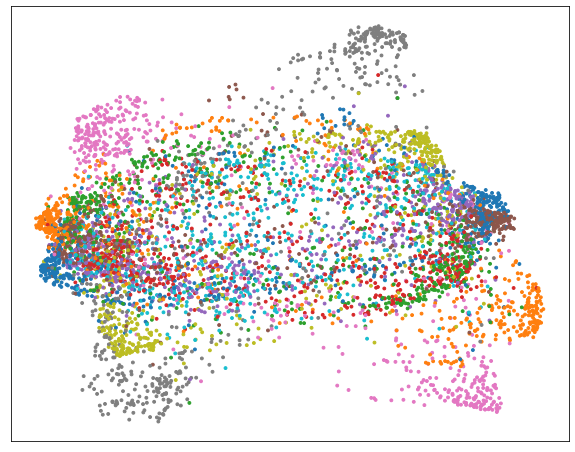

In [14]:
import scprep

n_embeds_per_pt = data_phate.shape[0] // len(patient_ids)

pid_labels = []

# for i in range(1, 15):
for i in patient_ids:
    pid_labels.extend([i] * n_embeds_per_pt)
pid_labels = np.array(pid_labels)

assert(len(pid_labels) == data_phate.shape[0])

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
scprep.plot.scatter2d(data_phate, c=pid_labels, discrete=True, ticks=False, legend=False, ax=ax, s=8)

outfile = os.path.join('phate', 'raw_unnormalized.npy')
np.save(outfile, data_phate)
plt.savefig(os.path.join('phate', 'raw_unnormalized.png'))

In [15]:
'''
A python implementation of the Earthmover distance metric.
'''

import math

from collections import Counter
from collections import defaultdict
from ortools.linear_solver import pywraplp


def euclidean_distance(x, y):
    return math.sqrt(sum((a - b)**2 for (a, b) in zip(x, y)))


def earthmover_distance(p1, p2):
    '''
    Output the Earthmover distance between the two given points.
    Arguments:
     - p1: an iterable of hashable iterables of numbers (i.e., list of tuples)
     - p2: an iterable of hashable iterables of numbers (i.e., list of tuples)
    '''
    dist1 = {x: float(count) / len(p1) for (x, count) in Counter(p1).items()}
    dist2 = {x: float(count) / len(p2) for (x, count) in Counter(p2).items()}
    solver = pywraplp.Solver('earthmover_distance', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)

    variables = dict()

    # for each pile in dist1, the constraint that says all the dirt must leave this pile
    dirt_leaving_constraints = defaultdict(lambda: 0)

    # for each hole in dist2, the constraint that says this hole must be filled
    dirt_filling_constraints = defaultdict(lambda: 0)

    # the objective
    objective = solver.Objective()
    objective.SetMinimization()

    for (x, dirt_at_x) in dist1.items():
        for (y, capacity_of_y) in dist2.items():
            amount_to_move_x_y = solver.NumVar(0, solver.infinity(), 'z_{%s, %s}' % (x, y))
            variables[(x, y)] = amount_to_move_x_y
            dirt_leaving_constraints[x] += amount_to_move_x_y
            dirt_filling_constraints[y] += amount_to_move_x_y
            objective.SetCoefficient(amount_to_move_x_y, euclidean_distance(x, y))

    for x, linear_combination in dirt_leaving_constraints.items():
        solver.Add(linear_combination == dist1[x])

    for y, linear_combination in dirt_filling_constraints.items():
        solver.Add(linear_combination == dist2[y])

    status = solver.Solve()
    if status not in [solver.OPTIMAL, solver.FEASIBLE]:
        raise Exception('Unable to find feasible solution')

    for ((x, y), variable) in variables.items():
        if variable.solution_value() != 0:
            cost = euclidean_distance(x, y) * variable.solution_value()
#             print("move {} dirt from {} to {} for a cost of {}".format(
#                 variable.solution_value(), x, y, cost))

    return objective.Value()

In [16]:
def list_of_tuples(points):
    return [tuple(point) for point in points]

In [20]:
from random import choice

models = [
    "raw_unnormalized.npy",
#     "data_forrest_paper_10pt_hiddendim64_bs64_mlp_md_mse_reg_lam1.0_manilam0.1_phate_shf_2_model_on_test_data_e4000_amlp_PHATE.npy",
#     "data_forrest_paper_10pt_hiddendim64_bs64_mlp_md_mse_reg_lam5.0_manilam0.1_phate_shf_model_on_test_data_e4000_amlp_PHATE.npy",
#     "data_forrest_paper_10pt_hiddendim64_bs64_mlp_md_mse_reg_lam10.0_manilam0.1_phate_shf_model_on_test_data_e4000_amlp_PHATE.npy",
#     "data_forrest_paper_10pt_hiddendim64_bs64_mlp_md_mse_reg_lam100.0_manilam0.1_phate_shf_2_model_on_test_data_e4000_amlp_PHATE.npy",
    
] 
test_range = 624

for model in models:
    data_phate = np.load(os.path.join('phate', model))
    point_sets = data_phate.reshape(len(patient_ids), test_range, -1)
    
    distances = []
    for i in range(10):
        j = choice([x for x in range(10) if x != i])
        
#     for i, j in [(0,5), (1,4), (2,6), (3, 7), (4, 2), (5,1), (6, 8), (7,9), (8,0), (9,3)]:
        print(f'subject {i} -- subject {j}')
        d = earthmover_distance(list_of_tuples(point_sets[i]), list_of_tuples(point_sets[j]))
        distances.append(d)

    print(np.array([distances]).mean())

subject 0 -- subject 7
subject 1 -- subject 6
subject 2 -- subject 3
subject 3 -- subject 2
subject 4 -- subject 7
subject 5 -- subject 0
subject 6 -- subject 0
subject 7 -- subject 0
subject 8 -- subject 2
subject 9 -- subject 8
0.00813568641159286


In [130]:
file_path = '/gpfs/milgram/scratch60/turk-browne/tw496/results/forrest_paper_10pt_hiddendim64_bs64_mlp_md_mse_reg_lam5.0_manilam0.1_phate_shf_2half_1/data_forrest_paper_10pt_hiddendim64_bs64_mlp_md_mse_reg_lam5.0_manilam0.1_phate_shf_2half_1_model_on_2half_data_e4000_amlp.npy'
model_name = file_path.split('/')[-1][:-4]

dataset = np.load(file_path)

In [131]:
data = dataset.reshape(dataset.shape[0]*dataset.shape[1], -1)

In [132]:
import phate

phate_op = phate.PHATE()
data_phate = phate_op.fit_transform(data)

outfile = os.path.join('phate', 'movie' + model_name + '_PHATE.npy')
np.save(outfile, data_phate)

Calculating PHATE...
  Running PHATE on 17990 observations and 64 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 23.72 seconds.
    Calculating affinities...
    Calculated affinities in 0.10 seconds.
  Calculated graph and diffusion operator in 23.84 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.37 seconds.
    Calculating KMeans...
    Calculated KMeans in 32.63 seconds.
  Calculated landmark operator in 34.98 seconds.
  Calculating optimal t...
    Automatically selected t = 17
  Calculated optimal t in 2.94 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 26.21 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.54 seconds.
Calculated PHATE in 93.53 seconds.


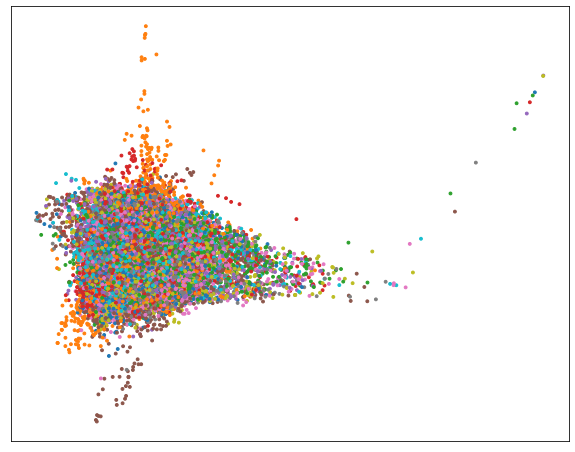

In [133]:
import scprep

n_embeds_per_pt = data_phate.shape[0] // len(patient_ids)

pid_labels = []

# for i in range(1, 15):
for i in patient_ids:
    pid_labels.extend([i] * n_embeds_per_pt)
pid_labels = np.array(pid_labels)

assert(len(pid_labels) == data_phate.shape[0])

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
scprep.plot.scatter2d(data_phate, c=pid_labels, discrete=True, ticks=False, legend=False, ax=ax, s=8)

plt.savefig(os.path.join('phate', 'movie' + model_name + '_PHATE.png'))

In [95]:
np.array([0.3, 0.5]).mean()

0.4

In [ ]:
subject 0 -- subject 4
subject 1 -- subject 7
subject 2 -- subject 1
subject 3 -- subject 1
subject 4 -- subject 0
subject 5 -- subject 1
subject 6 -- subject 3
subject 7 -- subject 5
subject 8 -- subject 0
subject 9 -- subject 6
0.009627612659771852


subject 0 -- subject 5
subject 1 -- subject 4
subject 2 -- subject 6
subject 3 -- subject 7
subject 4 -- subject 2
subject 5 -- subject 1
subject 6 -- subject 8
subject 7 -- subject 9
subject 8 -- subject 0
subject 9 -- subject 3
0.00778757148853305

0.008516956853